In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import shapely

In [2]:
print(shapely.__version__)
print(pd.__version__)

1.8.4
1.1.5


### Reading data

Main data source: https://public.opendatasoft.com/explore/dataset/georef-france-commune/

In [3]:
georef = gpd.read_file('georef-france-commune.geojson')
print(georef.head())

        com_name_upper bv2012_code com_siren_code               arrdep_name  \
0          VILLESISCLE       11049      211104385               Carcassonne   
1                AUBIN       12089      211200134  Villefranche-de-Rouergue   
2  BALAGUIER-SUR-RANCE       12208      211200191                    Millau   
3         LA CAVALERIE       12145      211200639                    Millau   
4  CLAIRVAUX-D'AVEYRON       12138      211200662                     Rodez   

  ept_code com_type com_uu2020_code   reg_name       bv2012_name com_code  \
0     None  commune           11000  Occitanie              Bram    11438   
1     None  commune           12302  Occitanie       Decazeville    12013   
2     None  commune           12000  Occitanie    Saint-Affrique    12019   
3     None  commune           12000  Occitanie            Millau    12063   
4     None  commune           12000  Occitanie  Marcillac-Vallon    12066   

   ... arrdep_code          ze2020_name com_area_code reg_code

In [4]:
georef.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34968 entries, 0 to 34967
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   com_name_upper        34968 non-null  object  
 1   bv2012_code           34955 non-null  object  
 2   com_siren_code        34955 non-null  object  
 3   arrdep_name           34826 non-null  object  
 4   ept_code              130 non-null    object  
 5   com_type              34968 non-null  object  
 6   com_uu2020_code       34955 non-null  object  
 7   reg_name              34968 non-null  object  
 8   bv2012_name           34955 non-null  object  
 9   com_code              34968 non-null  object  
 10  com_current_code      34968 non-null  object  
 11  com_cateaav2020_code  34955 non-null  object  
 12  ept_name              130 non-null    object  
 13  dep_code              34968 non-null  object  
 14  com_name              34968 non-null  object  

### Parsing inputs and loading additional data sources

In [5]:
# changing coordinate
georef['geometry'] = georef['geometry'].set_crs('EPSG:4326').to_crs('EPSG:3857')


In [6]:
# loading climatic zone
climatic_zone_detailed = pd.read_csv('zone_climatique.csv', index_col=[0]).to_dict()['Zone Climatique']
detailed_to_agg = {'H1A': 'H1', 'H1B': 'H1', 'H1C': 'H1', 'H2A': 'H2', 'H2B': 'H2', 'H2C': 'H2', 'H2D': 'H2', 'H3': 'H3'}
climatic_zone = {k: detailed_to_agg[item] for k, item in climatic_zone_detailed.items()}

In [7]:
# climatic zone
georef['dep_code'] = georef['dep_code'].astype(str)
georef['climatic_zone'] = georef['dep_code'].replace(climatic_zone)
georef['climatic_zone_detailed'] = georef['dep_code'].replace(climatic_zone_detailed)

georef = georef[georef['climatic_zone'].isin(['H1', 'H2', 'H3'])]

In [8]:
# define climatic zone
zones = dict()
for i in ['H1', 'H2', 'H3']:
    s = georef.loc[georef['climatic_zone'] == i, 'geometry']
    zones.update({i: gpd.GeoSeries(s.unary_union)})

In [9]:
color = {'H1': 'blue', 'H2': 'green', 'H3': 'yellow'}

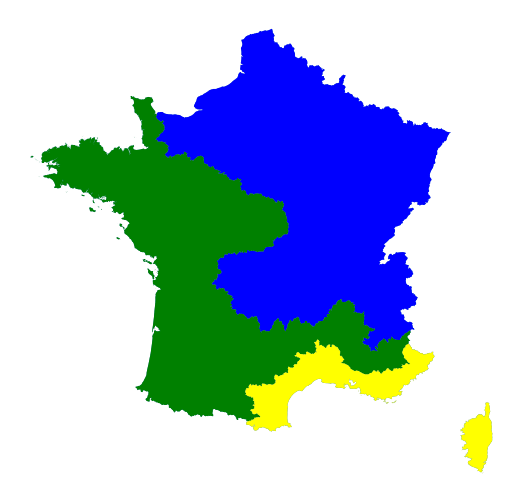

In [10]:
# plot climatic zone
fig, ax = plt.subplots(figsize=(16, 9))
georef['geometry'].plot(ax=ax)
for k, zone in zones.items():
    zone.plot(ax=ax, color=color[k])
ax.set_axis_off()
plt.show()

### Calculate distance for each commune to the climatic zone border

In [11]:
# formatting
zones = {k: item.iloc[0] for k, item in zones.items()}

In [16]:
# simple example with one city

city = georef.loc[2, :]
print(city['climatic_zone'])
print(city['geometry'].distance(zones['H1'].boundary))
print(city['geometry'].centroid.distance(zones['H1'].boundary))
print(city['geometry'].distance(zones['H2'].boundary))
print(city['geometry'].centroid.distance(zones['H2'].boundary))
print(city['geometry'].distance(zones['H3'].boundary))
print(city['geometry'].centroid.distance(zones['H3'].boundary))

H2
113949.21610151013
116561.34484739859
34042.75653951529
37111.65562969773
34042.75653951529
37111.65562969773


0        POINT (232595.869 5346738.279)
1        POINT (251173.533 5548150.334)
2        POINT (286817.834 5449357.777)
3        POINT (354402.415 5467242.501)
4        POINT (268115.458 5528585.814)
                      ...              
34963    POINT (584602.538 5945757.432)
34964    POINT (181109.095 5644201.233)
34965    POINT (205150.397 5669562.336)
34966    POINT (188765.684 5634805.389)
34967    POINT (527478.801 6151505.167)
Length: 34826, dtype: geometry

In [18]:
# example with multiple cities (10 cities)

georef.loc[:10, :].centroid.distance(zones['H1'].boundary)

/Users/lucas/opt/anaconda3/envs/geodata2/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


0     214899.158501
1      14154.692122
2     116561.344847
3     101039.328746
4      36373.424693
5      74324.967066
6     108967.329774
7      26315.673330
8     100192.612548
9      62961.301672
10     95767.933874
dtype: float64

In [19]:
# these following lines take a lot of times

for k in zones.keys():
    print(k)
    georef['distance {}'.format(k)] = georef.centroid.distance(zones[k].boundary)

H1


/Users/lucas/opt/anaconda3/envs/geodata2/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """


H2


/Users/lucas/opt/anaconda3/envs/geodata2/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """


H3


/Users/lucas/opt/anaconda3/envs/geodata2/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """


In [23]:
georef.to_csv('output.csv')

In [25]:
georef.drop('geometry', axis=1).to_csv('distance.csv')